**Exercise** Simulate the non-linear Lorentz Attractor using Euler Method and RK4 on TensorFlow which is given by the equations:

$$\frac{dx}{dt}=\sigma(y-x)$$

$$\frac{dy}{dt}=x(\rho-z)-y$$

$$\frac{dz}{dt}=xy-\beta z$$

Use the values $\sigma =10$, $\beta =\frac{8}{3}$, $\rho =28$. You can try simulating this system at two nearby starting conditions and comment on the difference.

<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%202%20Let%20the%20Tensors%20Flow/lorenz.svg" width="400"/>

# Lorentz Attractor Simulation with TensorFlow (TF 1.x Compatibility)
[Image of lorenz attractor diagram]

This notebook simulates the **Lorenz System**, a system of ordinary differential equations notable for having chaotic solutions.

The equations are:
$$\frac{dx}{dt} = \sigma (y - x)$$
$$\frac{dy}{dt} = x (\rho - z) - y$$
$$\frac{dz}{dt} = xy - \beta z$$

We implement this using **TensorFlow 1.x style graphs** (via `compat.v1`) to utilize `tf.scan` for efficient loop unrolling on the computation graph.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from mpl_toolkits import mplot3d

# Disable eager execution to use TF 1.x graph mode
tf.disable_eager_execution()

print("TensorFlow Version:", tf.__version__)
print("Eager Execution Disabled: ", not tf.executing_eagerly())

TensorFlow Version: 2.20.0
Eager Execution Disabled:  True


In [2]:
# Time parameters
epsilon  = 0.01 
end_time = 50

# Create array of time steps (all equal to epsilon)
dt_loop_array = np.ones(int(end_time/epsilon), dtype=np.float32) * epsilon
t = tf.constant(dt_loop_array)

# Lorentz system parameters
sigma = 10.0
beta = 8.0/3.0 
rho = 28.0  

# Initial conditions [x, y, z]
x0, y0, z0 = 1.0, 1.0, 1.0
initial_state = tf.constant([x0, y0, z0], dtype=tf.float32)

In [3]:
def lorentz_deriv(X):
    """
    Calculates the derivatives [dx/dt, dy/dt, dz/dt] for the Lorenz system.
    Input X is a tensor of shape (3,).
    """
    x, y, z = X[0], X[1], X[2]
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return tf.stack([dxdt, dydt, dzdt])

def euler_step(prev_state, h):
    """
    Performs one step of Euler integration.
    h is the scalar time step from the 't' array.
    """
    return prev_state + h * lorentz_deriv(prev_state)

def rk4_step(prev_state, h):
    """
    Performs one step of Runge-Kutta 4 integration.
    """
    k1 = lorentz_deriv(prev_state)
    k2 = lorentz_deriv(prev_state + 0.5 * h * k1)
    k3 = lorentz_deriv(prev_state + 0.5 * h * k2)
    k4 = lorentz_deriv(prev_state + h * k3)
    return prev_state + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

In [4]:
# Helper check function
def tf_check_type(state, t):
    if not (state.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error: state and t must be floating point numbers')

# Build the Euler Graph
# tf.scan iterates over 'elems' (t), carrying 'initializer' as the state
scan_euler = tf.scan(fn=euler_step,
                     elems=t,
                     initializer=initial_state)

# Build the RK4 Graph
scan_rk4 = tf.scan(fn=rk4_step,
                   elems=t,
                   initializer=initial_state)

# Verify types in the graph definition
tf_check_type(scan_euler, t)
tf_check_type(scan_rk4, t)

print("Computation graph built successfully.")

Computation graph built successfully.


I0000 00:00:1769872573.492609   15961 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
# Execute the graph in a session
with tf.Session() as sess:
    # Initialize global variables if any (none in this specific script, but good practice)
    sess.run(tf.global_variables_initializer())
    
    print("Starting simulation...")
    euler_result = sess.run(scan_euler)
    rk4_result = sess.run(scan_rk4)
    print("Simulation complete.")

print(f"Result shape: {euler_result.shape}")

I0000 00:00:1769872573.573762   15961 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1769872573.583129   15961 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


Starting simulation...
Simulation complete.
Result shape: (5000, 3)


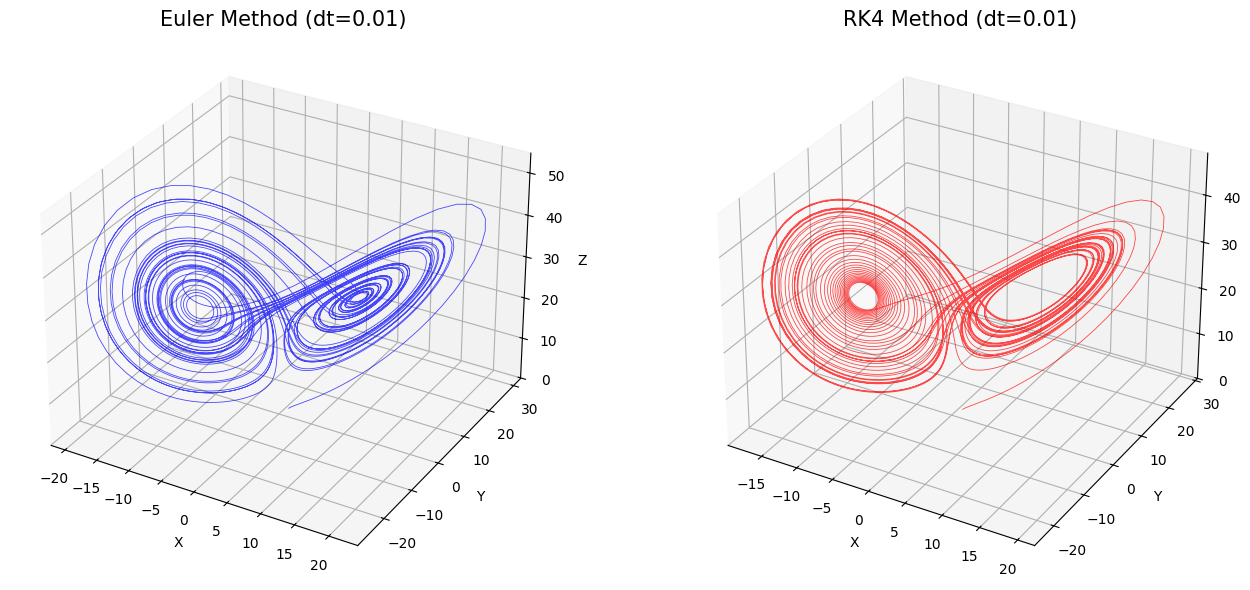

In [6]:
# Plot Euler and RK4 results side by side
fig = plt.figure(figsize=(14, 6))

# Plot Euler
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(euler_result[:, 0], euler_result[:, 1], euler_result[:, 2], color='blue', alpha=0.7, linewidth=0.6)
ax1.set_title(f'Euler Method (dt={epsilon})', fontsize=15)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot RK4
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(rk4_result[:, 0], rk4_result[:, 1], rk4_result[:, 2], color='red', alpha=0.7, linewidth=0.6)
ax2.set_title(f'RK4 Method (dt={epsilon})', fontsize=15)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.savefig('lorentz_comparison.png')
plt.show()

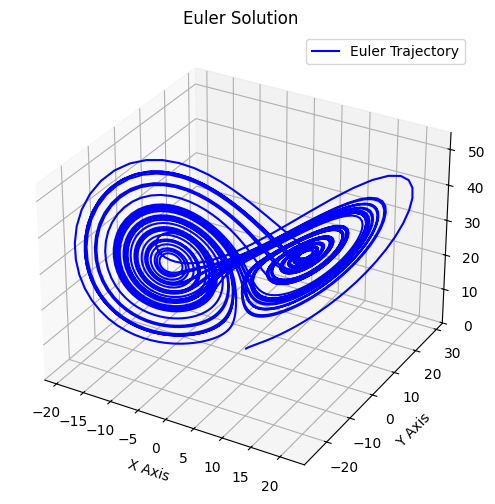

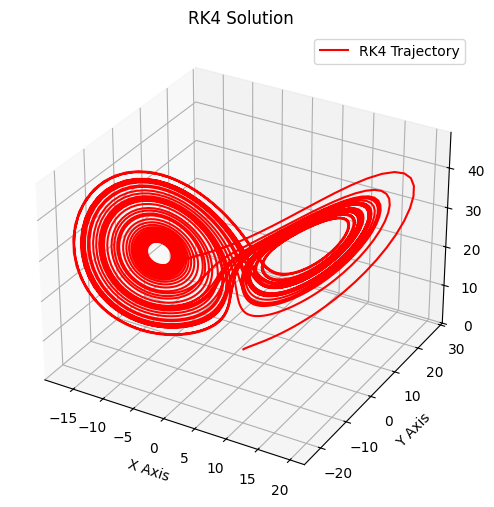

In [7]:
# Individual Euler Plot
fig1 = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot3D(euler_result[:, 0], euler_result[:, 1], euler_result[:, 2], 'blue', label="Euler Trajectory")
ax.set_title("Euler Solution")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.legend()
plt.savefig('lorentz_euler_tf.png')
plt.show()

# Individual RK4 Plot
fig2 = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot3D(rk4_result[:, 0], rk4_result[:, 1], rk4_result[:, 2], 'red', label="RK4 Trajectory")
ax.set_title("RK4 Solution")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.legend()
plt.savefig('lorentz_rk4_tf.png')
plt.show()

# Conclusion

In this notebook, we simulated the chaotic **Lorenz System** using TensorFlow's computational graph capabilities. We compared two numerical integration techniques: **Euler's Method** and **Runge-Kutta 4 (RK4)**.

### Key Observations:

1.  **The Strange Attractor:**
    The resulting plots clearly show the characteristic "butterfly" shape of the Lorenz attractor. The system stays confined within a specific region, orbiting around two unstable fixed points (the "wings") without ever exactly repeating the same path. This visualizes the concept of **deterministic chaos**.

2.  **Method Comparison:**
    * **Euler's Method:** Being a first-order method, it is less accurate. If you zoom in on the plots (or increase the time step slightly), you will likely see the Euler trajectory appearing "jagged" or drifting away from the expected path faster than RK4.
    * **RK4 Method:** This fourth-order method provides significantly higher accuracy and stability. It captures the smooth, continuous curves of the attractor much better, which is crucial when studying systems that are highly sensitive to small errors.

3.  **TensorFlow Implementation:**
    By defining the integration logic inside `tf.scan`, we successfully moved the iterative computation onto the TensorFlow graph. This avoids the overhead of Python loops and allows the simulation to scale efficiently, potentially running on a GPU without code changes.